# RASSP prediction

In [ ]:
!pip install matchms
!pip install jupyterlab
!pip install rdkit pandas matplotlib cython numba scikit-learn
!pip install python-igraph ruffus tqdm boto3 networkx graphviz tensorflow tensorboardX diskcache PyYAML natsort pyarrow seaborn SQLAlchemy click
!pip install git+https://github.com/thejonaslab/tinygraph.git

In [ ]:
!git clone https://github.com/ljocha/rassp-public.git

In [ ]:
import os
os.chdir('/content/rassp-public')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
!pip install cython
!pip install numpy

In [ ]:
!pip install -e .
!python -c 'import rassp.msutil'

In [ ]:
import pandas as pd
import urllib
import pickle
import rassp
from rassp import netutil
from rdkit import Chem
import numpy as np
import torch
import matchms
import matplotlib.pyplot as plt

In [ ]:
from rassp import msutil,model
import sys
sys.modules['msutil'] = msutil
sys.modules['model'] = model

In [ ]:
test = pd.read_parquet('/content/drive/MyDrive/NIST_SMALL/smalltest.pq')

In [ ]:
use_gpu=True
# this are models from RASSP checkpoint saves
model = '/content/drive/MyDrive/RASSP/MODELS/small.80261075.00001606.model'
meta = '/content/drive/MyDrive/RASSP/MODELS/small.80173081.meta'

if use_gpu and not torch.cuda.is_available():
    use_gpu = False

    

predictor = netutil.PredModel(
    meta,
    model,
    USE_CUDA=use_gpu,
    data_parallel=False,
)


In [ ]:
sample = test

In [ ]:

mols = [ Chem.AddHs(Chem.Mol(m)) for m in sample.rdmol ]

predictions = predictor.pred(
    mols,
    progress_bar=True,
    normalize_pred=True,
    output_hist_bins=True,
    batch_size=1, # XXX
    dataloader_config={
        'pin_memory': False,
        'num_workers': 0, # XXX
        'persistent_workers': False,
    },
    benchmark_dataloader=False,
)


100%|██████████| 28.1k/28.1k [1:54:27<00:00, 4.09it/s]


In [ ]:
pred = predictions['pred_binned']
true = [ np.stack(list(t)) for t in sample.spect ]

In [ ]:
def to_matchms_spec(s):
    return matchms.Spectrum(mz=s[:,0].astype(float),intensities=s[:,1].astype(float))

In [ ]:
matchms.set_matchms_logger_level("ERROR")

# normal DP
sim_dp = matchms.similarity.CosineGreedy(mz_power=1., intensity_power=.5)
dp = [ sim_dp.pair(to_matchms_spec(true[i]),to_matchms_spec(pred[i])) for i in range(len(true)) ]
dp = np.array([ float(s['score']) for s in dp ])

sim_sdp = matchms.similarity.CosineGreedy(mz_power=3., intensity_power=.6)
sdp = [ sim_sdp.pair(to_matchms_spec(true[i]),to_matchms_spec(pred[i])) for i in range(len(true)) ]
sdp = np.array([ float(s['score']) for s in sdp ])

In [ ]:
win = 1
smooth_dp = np.convolve(dp, np.ones(win)/win, mode='valid')
smooth_sdp = np.convolve(sdp, np.ones(win)/win, mode='valid')

plt.plot(smooth_dp,label='dp')
plt.plot(smooth_sdp,label='sdp')
plt.legend()
#plt.plot([ float(s['matches']) for s in scores ])
plt.show()

In [ ]:
bins = 70
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.hist(dp,label='dp',bins=bins)
plt.title('dp')
plt.subplot(122)
plt.hist(sdp,label='sdp',bins=bins)
plt.title('sdp')
#lt.legend()
plt.show()

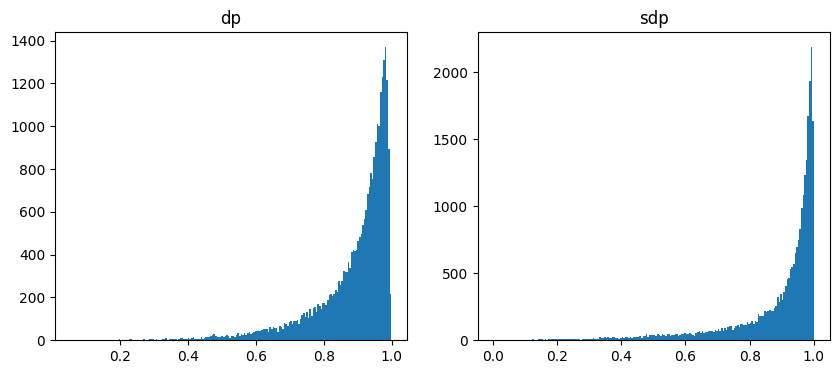

In [ ]:
bins = 200
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.hist(dp,label='dp',bins=bins)
plt.title('dp')
plt.subplot(122)
plt.hist(sdp,label='sdp',bins=bins)
plt.title('sdp')
plt.show()

In [ ]:
print(f" | DotProduct mean is: {np.mean(dp)} and standard deviation is {np.std(dp)}")

print(f" | SteinDotProduct mean is: {np.mean(sdp)} and standard deviation is {np.std(sdp)}")